In [53]:
import pandas as pd
import psycopg2
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
from urllib.parse import quote_plus

In [54]:
# Fetch database credentials from .env
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

# Encode the password to handle special characters
password_encoded = quote_plus(DB_PASSWORD)

# Use only this connection string (DO NOT create another one)
connection_url = f'postgresql://{DB_USER}:{password_encoded}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# Use this engine throughout the script
engine = create_engine(connection_url)

In [55]:
# Loading the processed data
query = "SELECT * FROM processed_churn_data"
df = pd.read_sql(query, engine)

In [56]:
# Display dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer_ID                    10000 non-null  object 
 1   Product_ID                     10000 non-null  object 
 2   Transaction_ID                 10000 non-null  object 
 3   Purchase_Frequency             10000 non-null  int64  
 4   Average_Order_Value            10000 non-null  float64
 5   Most_Frequent_Category         10000 non-null  object 
 6   Time_Between_Purchases         10000 non-null  int64  
 7   Region                         10000 non-null  object 
 8   Churn_Probability              10000 non-null  float64
 9   Lifetime_Value                 10000 non-null  float64
 10  Launch_Date                    10000 non-null  object 
 11  Peak_Sales_Date                10000 non-null  object 
 12  Season                         10000 non-null  

In [57]:
# Check for missing values
print(df.isnull().sum())

Customer_ID                      0
Product_ID                       0
Transaction_ID                   0
Purchase_Frequency               0
Average_Order_Value              0
Most_Frequent_Category           0
Time_Between_Purchases           0
Region                           0
Churn_Probability                0
Lifetime_Value                   0
Launch_Date                      0
Peak_Sales_Date                  0
Season                           0
Preferred_Purchase_Times         0
Retention_Strategy               0
launch_year                      0
launch_month                     0
customer_tenure                  0
recency                          0
engagement_score                 0
purchase_freq_scaled             0
avg_order_value_scaled           0
time_between_scaled              0
customer_tenure_scaled           0
recency_scaled                   0
engagement_score_scaled          0
purchase_freq_standardized       0
avg_order_value_standardized     0
time_between_standar

In [58]:
# Check target variable distribution
print(df["Churn_Probability"].value_counts(normalize=True) * 100)

Churn_Probability
0.84    1.26
0.90    1.22
0.41    1.22
0.12    1.16
0.04    1.14
        ... 
0.92    0.79
0.06    0.79
0.59    0.78
1.00    0.51
0.00    0.35
Name: proportion, Length: 101, dtype: float64


In [59]:
df_copy = df.copy()

In [60]:
# Defining relevant fetures(X) and target variable(y)

# Target variable (Churn label - Binary Classification) - Converts probabilities to 0 or 1
df_copy["Churn_Label"] = (df_copy["Churn_Probability"] > 0.5).astype(int)

# Drop unnecessary columns (IDs, textual info)
drop_cols = [
    "Customer_ID", "Product_ID", "Transaction_ID",
    "Launch_Date", "Peak_Sales_Date", "Most_Frequent_Category",
    "Season", "Preferred_Purchase_Times", "Retention_Strategy"
]

# Features (X) and Target (y)
X = df_copy.drop(columns=drop_cols + ["Churn_Probability", "Churn_Label"])
y = df_copy["Churn_Label"]

print("Feature Set Shape:", X.shape)
print("Target Variable Distribution:\n", y.value_counts(normalize=True) * 100)


Feature Set Shape: (10000, 27)
Target Variable Distribution:
 Churn_Label
0    50.69
1    49.31
Name: proportion, dtype: float64


In [61]:
# Splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Splitting data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training Set Shape:", X_train.shape, y_train.shape)
print("Test Set Shape:", X_test.shape, y_test.shape)

Training Set Shape: (8000, 27) (8000,)
Test Set Shape: (2000, 27) (2000,)


In [62]:
# Checking class distribution after splitting
print("Training Set Churn Distribution:\n", y_train.value_counts(normalize=True) * 100)
print("\nTest Set Churn Distribution:\n", y_test.value_counts(normalize=True) * 100)

Training Set Churn Distribution:
 Churn_Label
0    50.6875
1    49.3125
Name: proportion, dtype: float64

Test Set Churn Distribution:
 Churn_Label
0    50.7
1    49.3
Name: proportion, dtype: float64


Observations:
- Train and Test sets maintain the same class distribution, so there is no imbalance issue

In [63]:
# Selecting only numeric features for scaling
numeric_cols = X_train.select_dtypes(include = ["int64", "float64"]).columns.tolist()
print("Numeric Features for Scaling:\n", numeric_cols)

Numeric Features for Scaling:
 ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'Lifetime_Value', 'launch_year', 'launch_month', 'customer_tenure', 'recency', 'engagement_score', 'purchase_freq_scaled', 'avg_order_value_scaled', 'time_between_scaled', 'customer_tenure_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'avg_order_value_standardized', 'time_between_standardized', 'customer_tenure_standardized', 'recency_standardized', 'engagement_score_standardized', 'engagement_score_log', 'engagement_score_ma3']


In [64]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both train & test
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_cols]), columns=numeric_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_cols]), columns=numeric_cols, index=X_test.index)

X_train[numeric_cols] = X_train[numeric_cols].astype(float)
X_test[numeric_cols] = X_test[numeric_cols].astype(float)

# Replace original numeric columns with scaled versions
X_train.update(X_train_scaled)
X_test.update(X_test_scaled)

# Confirm scaling
print("Feature Scaling Completed!")
print("\nMean of Scaled Features (Train):\n", X_train[numeric_cols].mean())
print("\nStandard Deviation of Scaled Features (Train):\n", X_train[numeric_cols].std())

Feature Scaling Completed!

Mean of Scaled Features (Train):
 Purchase_Frequency              -5.639933e-17
Average_Order_Value             -2.779998e-16
Time_Between_Purchases          -4.973799e-17
Lifetime_Value                   9.148238e-17
launch_year                     -8.935075e-15
launch_month                     8.837375e-17
customer_tenure                  2.167155e-16
recency                          1.483258e-16
engagement_score                 2.842171e-17
purchase_freq_scaled            -5.084821e-17
avg_order_value_scaled           1.127987e-16
time_between_scaled              6.039613e-17
customer_tenure_scaled           2.553513e-17
recency_scaled                  -3.552714e-18
engagement_score_scaled         -1.776357e-18
purchase_freq_standardized       3.241851e-17
avg_order_value_standardized    -2.842171e-17
time_between_standardized       -3.375078e-17
customer_tenure_standardized     1.110223e-16
recency_standardized             2.575717e-17
engagement_score_s

In [65]:
# Checking if there are any categorical columns left
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical Features:", cat_cols)

Categorical Features: ['Region', 'customer_tenure_group', 'engagement_category', 'recently_active']


In [66]:
print(X_train["customer_tenure_group"].unique())  
print(X_train["engagement_category"].unique())

['Medium' 'Loyal' 'New']
['Low' 'High' 'Medium']


In [67]:
# Applying encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# One-Hot Encoding for 'Region'
ohe = OneHotEncoder(drop="first", sparse_output=False)  # drop="first" to avoid dummy variable trap
region_encoded = pd.DataFrame(ohe.fit_transform(X_train[["Region"]]), columns=ohe.get_feature_names_out(["Region"]), index=X_train.index)

# Label Encoding for 'customer_tenure_group'
tenure_order = {"New": 0, "Medium": 1, "Loyal": 2}  # Defining order
X_train["customer_tenure_group"] = X_train["customer_tenure_group"].map(tenure_order)
X_test["customer_tenure_group"] = X_test["customer_tenure_group"].map(tenure_order)

# Label Encoding for 'engagement_category'
engagement_order = {"Low": 0, "Medium": 1, "High": 2}  
X_train["engagement_category"] = X_train["engagement_category"].map(engagement_order)
X_test["engagement_category"] = X_test["engagement_category"].map(engagement_order)

# Ensure no missing values in 'recently_active' before encoding
print("Before Encoding:", X_train["recently_active"].unique())

# Apply binary encoding
X_train["recently_active"] = X_train["recently_active"].map({"No": 0, "Yes": 1})
X_test["recently_active"] = X_test["recently_active"].map({"No": 0, "Yes": 1})

# Verify after encoding
print("After Encoding:", X_train["recently_active"].unique())

# Merging encoded region back
X_train = pd.concat([X_train.drop(columns=["Region"]), region_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=["Region"]), pd.DataFrame(ohe.transform(X_test[["Region"]]), columns=ohe.get_feature_names_out(["Region"]), index=X_test.index)], axis=1)

print("Categorical Encoding Completed!")
print("\nUpdated Feature Set Shape:", X_train.shape)

Before Encoding: ['Inactive']
After Encoding: [nan]
Categorical Encoding Completed!

Updated Feature Set Shape: (8000, 29)


In [68]:
# Check missing values in training and test set
print("Missing values in X_train:\n", X_train.isnull().sum())
print("\nMissing values in X_test:\n", X_test.isnull().sum())

Missing values in X_train:
 Purchase_Frequency                  0
Average_Order_Value                 0
Time_Between_Purchases              0
Lifetime_Value                      0
launch_year                         0
launch_month                        0
customer_tenure                     0
recency                             0
engagement_score                    0
purchase_freq_scaled                0
avg_order_value_scaled              0
time_between_scaled                 0
customer_tenure_scaled              0
recency_scaled                      0
engagement_score_scaled             0
purchase_freq_standardized          0
avg_order_value_standardized        0
time_between_standardized           0
customer_tenure_standardized        0
recency_standardized                0
engagement_score_standardized       0
engagement_score_log                0
customer_tenure_group               0
engagement_category                 0
recently_active                  8000
engagement_score_ma3  

In [69]:
print(X_train["recently_active"].unique())
print(X_test["recently_active"].unique())

[nan]
[nan]


In [70]:
X_train["recently_active"] = X_train["recently_active"].map({"Inactive": 0, "Active": 1}).fillna(0)
X_test["recently_active"] = X_test["recently_active"].map({"Inactive": 0, "Active": 1}).fillna(0)

In [71]:
print("After Encoding:", X_train["recently_active"].unique())

After Encoding: [0.]


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=500)

# Train the model
log_reg.fit(X_train, y_train)

# Predictions
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Model Evaluation
print("Logistic Regression Performance:\n")

# Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Precision, Recall, F1-score
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))

Logistic Regression Performance:

Train Accuracy: 0.5145
Test Accuracy: 0.492

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.50      0.58      0.54      1014
           1       0.48      0.40      0.44       986

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



Observations:
- Model is not perorming well it's accuracy is close to random guessing ≈50%
- Next step: Checking for any data imbalance

In [73]:
# Checking reason for moel under performance
# Checking class distribution
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Churn_Label
0    0.506875
1    0.493125
Name: proportion, dtype: float64
Churn_Label
0    0.507
1    0.493
Name: proportion, dtype: float64


Observations:
- Dataset is almost perfectly balanced. So class imbalance is not the reason for the poor model performance

In [74]:
# Checking for the other factors that could be affecting model performance
feature_importance = pd.DataFrame({"Feature": X_train.columns, "Coefficient": log_reg.coef_[0]})
feature_importance_sorted = feature_importance.sort_values(by="Coefficient", ascending=False)

print("Top 10 Important Features:")
print(feature_importance_sorted.head(10))
print("\nLeast Important Features:")
print(feature_importance_sorted.tail(10))

Top 10 Important Features:
                         Feature  Coefficient
27          Region_North America     0.080948
14       engagement_score_scaled     0.059735
25          engagement_score_ma3     0.047038
21          engagement_score_log     0.034293
6                customer_tenure     0.030947
18  customer_tenure_standardized     0.030947
23           engagement_category     0.029718
28          Region_South America     0.012326
2         Time_Between_Purchases     0.012235
17     time_between_standardized     0.012235

Least Important Features:
                          Feature  Coefficient
20  engagement_score_standardized    -0.007133
5                    launch_month    -0.007940
1             Average_Order_Value    -0.009018
16   avg_order_value_standardized    -0.009018
10         avg_order_value_scaled    -0.009018
3                  Lifetime_Value    -0.028308
4                     launch_year    -0.030947
22          customer_tenure_group    -0.038189
12         custom

Observations:
- Highest coefficient is only 0.080948, no strong predictors of churn exist
- Many features are close to zero, suggesting weak correlations with the target variable

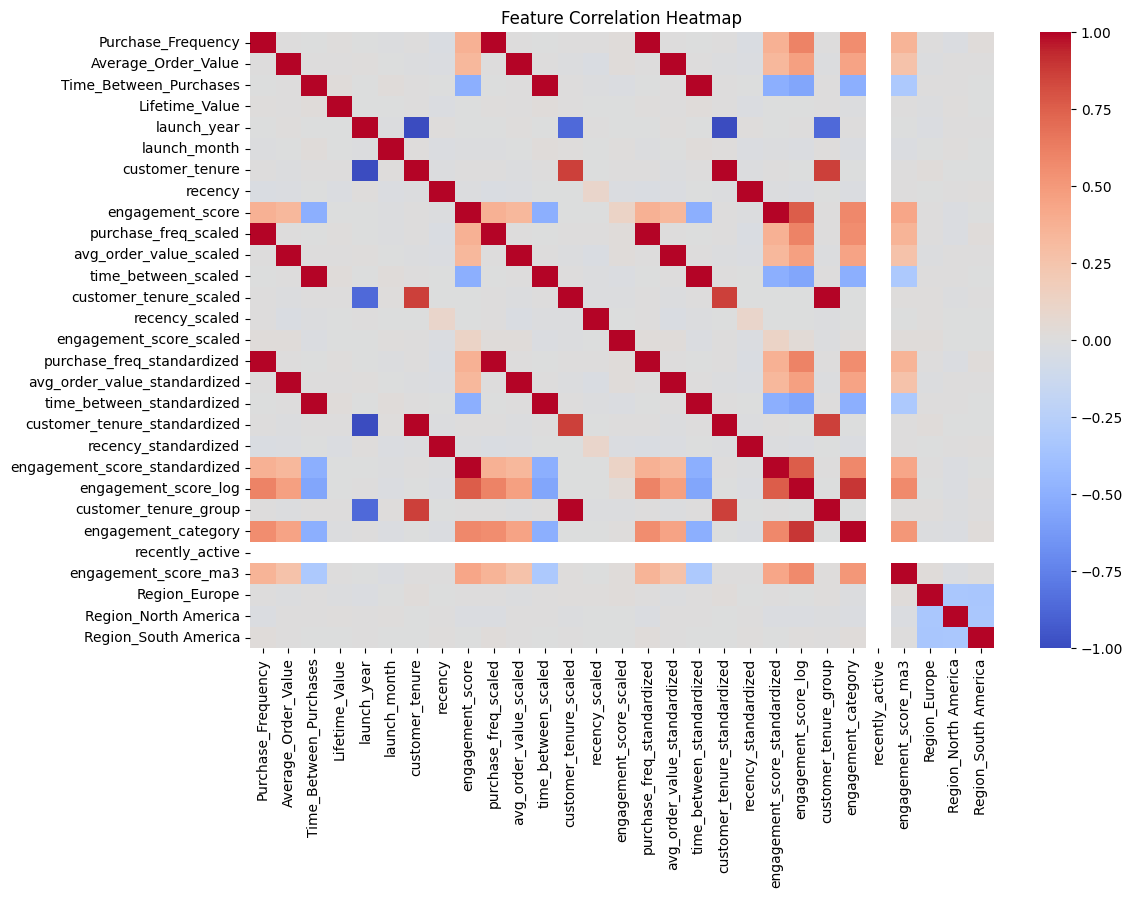

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(X_train.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [76]:
# Using Random Forest Instead of Logistic Regression - In case churn patterns are nonlinear or a tree-based model 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Test Accuracy: 0.497

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.56      0.53      1014
           1       0.49      0.43      0.46       986

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.50      0.50      0.49      2000



Observations:
- Test Accuracy: 0.497 (49.7%) almost random guessing (50%)
- F1-score is low, meaning the model isn’t learning useful patterns 

In [77]:
# Dropping redundant features with high correlation
drop_features = ["launch_year", "launch_month", "Lifetime_Value",
                 "customer_tenure_scaled", "customer_tenure_standardized", 
                 "engagement_score_standardized", "avg_order_value_scaled", 
                 "avg_order_value_standardized"]

X_train_selected = X_train.drop(columns=drop_features)
X_test_selected = X_test.drop(columns=drop_features)

In [78]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_selected, y_train)

y_pred_xgb = xgb_model.predict(X_test_selected)

print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Test Accuracy: 0.506

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.54      0.52      1014
           1       0.50      0.47      0.49       986

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



Observations:
- The test accuracy is 50.6% which is still low - model might not be learning well

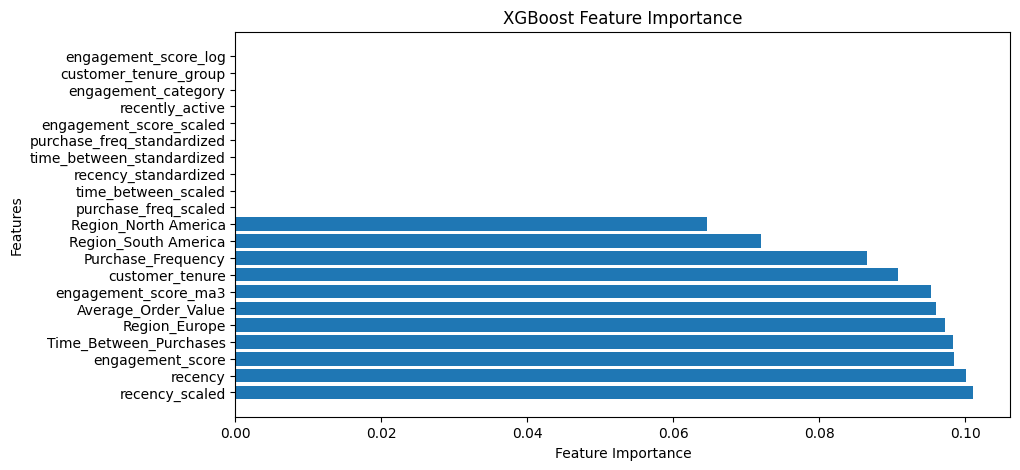

In [79]:
# Plotting to check the feature importance
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance
feature_importance = pd.DataFrame({"Feature": X_train_selected.columns, "Importance": xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

In [80]:
xgb_model = XGBClassifier(
    n_estimators=300,       # More trees
    learning_rate=0.05,     # Lower learning rate
    max_depth=5,            # Limit tree depth
    subsample=0.8,          # Use 80% of data per tree
    colsample_bytree=0.8,   # Use 80% of features per tree
    random_state=42
)

xgb_model.fit(X_train_selected, y_train)
y_pred_xgb = xgb_model.predict(X_test_selected)

print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Test Accuracy: 0.516

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.54      0.53      1014
           1       0.51      0.49      0.50       986

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [81]:
xgb_model = XGBClassifier(
    n_estimators=300,  
    learning_rate=0.05,  
    max_depth=5,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    scale_pos_weight=1.1,  # Slight weight adjustment
    random_state=42
)

xgb_model.fit(X_train_selected, y_train)
y_pred_xgb = xgb_model.predict(X_test_selected)

print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Test Accuracy: 0.5175

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.45      0.49      1014
           1       0.51      0.58      0.54       986

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



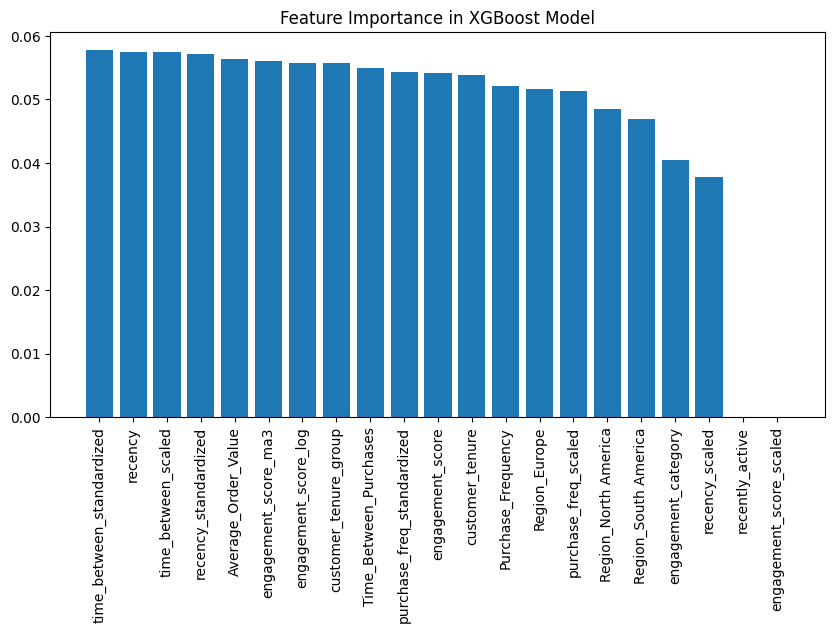

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)), np.array(X_train_selected.columns)[sorted_idx], rotation=90)
plt.title("Feature Importance in XGBoost Model")
plt.show()

In [83]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 1.5, 2],
    'gamma': [0, 0.1, 0.5]
}

xgb_grid = GridSearchCV(XGBClassifier(random_state=42), param_grid, scoring='accuracy', cv=3, n_jobs=-1)
xgb_grid.fit(X_train_selected, y_train)

print("Best parameters:", xgb_grid.best_params_)

Best parameters: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.7}


In [ ]:
xgb_final = XGBClassifier(
    colsample_bytree=0.7,
    gamma=0.5,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    scale_pos_weight=1,
    subsample=0.7,
    random_state=42
)

xgb_final.fit(X_train_selected, y_train)
y_pred_final = xgb_final.predict(X_test_selected)

# Performance Metrics
print("Final XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

Final XGBoost Test Accuracy: 0.497

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.62      0.55      1014
           1       0.49      0.38      0.42       986

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.50      0.50      0.49      2000



In [91]:
xgb_final = XGBClassifier(
    colsample_bytree=0.7,
    gamma=0.5,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=300,
    scale_pos_weight=1,
    subsample=0.7,
    random_state=42
)

xgb_final.fit(X_train_selected, y_train)
y_pred_final = xgb_final.predict(X_test_selected)

# Predictions
y_pred_final = xgb_final.predict(X_test_selected)

# Performance Metrics
print("Final XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

Final XGBoost Test Accuracy: 0.501

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.53      0.52      1014
           1       0.49      0.47      0.48       986

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [92]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(4055), np.int64(1): np.int64(3945)}


In [93]:
scale_pos_weight = counts[0] / counts[1]  # Only if 0 > 1 or vice versa

In [94]:
xgb_final = XGBClassifier(
    colsample_bytree=0.8,  # Increase diversity of trees
    gamma=0.3,  # Reduce overfitting slightly
    learning_rate=0.05,  # Increase learning speed
    max_depth=5,  # Allow deeper splits
    n_estimators=500,  # Train longer for better learning
    scale_pos_weight=1,  # Adjust if class imbalance exists
    subsample=0.8,  # Use more data per tree
    random_state=42
)

xgb_final.fit(X_train_selected, y_train)
y_pred_final = xgb_final.predict(X_test_selected)

# Performance Metrics
print("Final XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

Final XGBoost Test Accuracy: 0.5225

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.56      0.54      1014
           1       0.52      0.49      0.50       986

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



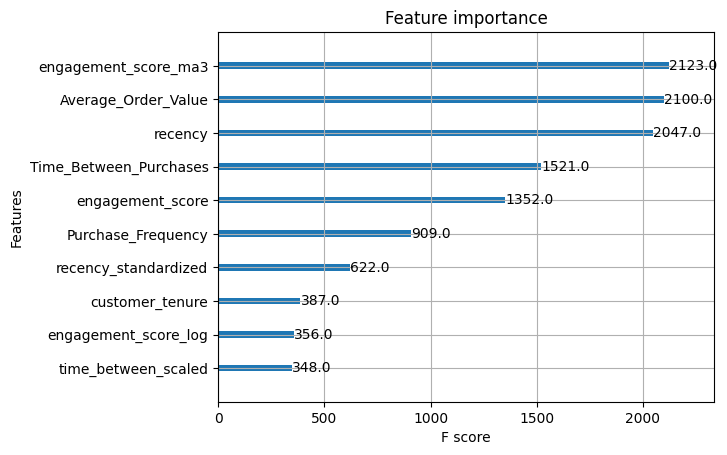

In [95]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_final, max_num_features=10)
plt.show()

Observations:
- Most important features that strongly influence predictions are - 'engagement_score_ma3', 'Average_Order_Value', 'recency'
- Low impact features are - 'engagement_score_log', 'time_between_scaled', 'customer_tenure'

In [96]:
# Dropping the low impact features
drop_features = ['engagement_score_log', 'time_between_scaled', 'customer_tenure']
X_train_selected_new = X_train_selected.drop(columns=drop_features)
X_test_selected_new = X_test_selected.drop(columns=drop_features)

xgb_final = XGBClassifier(
    colsample_bytree=0.8,  
    gamma=0.3,  
    learning_rate=0.05,  
    max_depth=5,  
    n_estimators=500,  
    scale_pos_weight=counts[0] / counts[1],  # Use correct weight
    subsample=0.8,  
    random_state=42
)

xgb_final.fit(X_train_selected_new, y_train)
y_pred_final = xgb_final.predict(X_test_selected_new)

# Performance Metrics
print("Final XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

Final XGBoost Test Accuracy: 0.512

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.53      0.52      1014
           1       0.51      0.50      0.50       986

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [97]:
X_train_selected.describe()

,Purchase_Frequency,Average_Order_Value,Time_Between_Purchases,customer_tenure,recency,engagement_score,purchase_freq_scaled,time_between_scaled,recency_scaled,engagement_score_scaled,...,time_between_standardized,recency_standardized,engagement_score_log,customer_tenure_group,engagement_category,recently_active,engagement_score_ma3,Region_Europe,Region_North America,Region_South America
count,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,...,8.000000e+03,8.000000e+03,8.000000e+03,8000.00000,8000.000000,8000.0,8.000000e+03,8000.000000,8000.00000,8000.00000
mean,-5.639933e-17,-2.779998e-16,-4.973799e-17,2.167155e-16,1.483258e-16,2.842171e-17,-5.084821e-17,6.039613e-17,-3.552714e-18,-1.776357e-18,...,-3.375078e-17,2.575717e-17,-1.598721e-17,1.33000,0.986625,0.0,-1.560974e-16,0.255000,0.24550,0.25325
std,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,0.47157,0.822971,0.0,1.000063e+00,0.435888,0.43041,0.43490
min,-1.617811e+00,-1.721628e+00,-1.690650e+00,-2.443405e+00,-1.723217e+00,-6.633324e-01,-1.617811e+00,-1.690650e+00,-5.598925e-02,-1.118104e-02,...,-1.690650e+00,-1.723217e+00,-2.719719e+00,0.00000,0.000000,0.0,-3.262189e+00,0.000000,0.00000,0.00000
25%,-8.942721e-01,-8.622285e-01,-8.824903e-01,-1.218947e+00,-8.647693e-01,-5.110304e-01,-8.942721e-01,-8.824903e-01,-5.598925e-02,-1.118104e-02,...,-8.824903e-01,-8.647693e-01,-6.716350e-01,1.00000,0.000000,0.0,-6.781846e-01,0.000000,0.00000,0.00000
50%,1.015216e-02,-6.657776e-03,6.485482e-03,5.510058e-03,-6.321618e-03,-3.079610e-01,1.015216e-02,6.485482e-03,-5.598925e-02,-1.118104e-02,...,6.485482e-03,-6.321618e-03,2.967537e-02,1.00000,1.000000,0.0,4.174579e-03,0.000000,0.00000,0.00000
75%,9.145764e-01,8.796896e-01,8.550533e-01,1.229967e+00,8.804265e-01,8.125524e-02,9.145764e-01,8.550533e-01,-5.598925e-02,-1.118104e-02,...,8.550533e-01,8.804265e-01,6.661990e-01,2.00000,2.000000,0.0,6.782518e-01,1.000000,0.00000,1.00000
max,1.638116e+00,1.723629e+00,1.703621e+00,1.229967e+00,1.710574e+00,1.099623e+01,1.638116e+00,1.703621e+00,1.786057e+01,8.943713e+01,...,1.703621e+00,1.710574e+00,3.094482e+00,2.00000,2.000000,0.0,3.486651e+00,1.000000,1.00000,1.00000


In [98]:
xgb_final = XGBClassifier(
    colsample_bytree=0.9,  
    gamma=0.2,  
    learning_rate=0.05,  
    max_depth=6,  # Allow deeper splits
    n_estimators=700,  # Train longer
    scale_pos_weight=counts[0] / counts[1],  
    subsample=0.9,  
    random_state=42
)

xgb_final.fit(X_train_selected, y_train)
y_pred_final = xgb_final.predict(X_test_selected)

# Performance Metrics
print("Final XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

Final XGBoost Test Accuracy: 0.511

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.52      0.52      1014
           1       0.50      0.50      0.50       986

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [99]:
print("Features in X_train_selected_new:", X_train_selected_new.columns)

Features in X_train_selected_new: Index(['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases',
       'recency', 'engagement_score', 'purchase_freq_scaled', 'recency_scaled',
       'engagement_score_scaled', 'purchase_freq_standardized',
       'time_between_standardized', 'recency_standardized',
       'customer_tenure_group', 'engagement_category', 'recently_active',
       'engagement_score_ma3', 'Region_Europe', 'Region_North America',
       'Region_South America'],
      dtype='object')


In [101]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in y_train:", dict(zip(unique, counts)))

Class distribution in y_train: {np.int64(0): np.int64(4055), np.int64(1): np.int64(3945)}


In [102]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected_new, y_train)

In [103]:
xgb_final = XGBClassifier(
    scale_pos_weight=2,  # Try different values (1.5 to 5) based on class imbalance
    learning_rate=0.05,
    max_depth=6,
    n_estimators=700,
    colsample_bytree=0.9,
    subsample=0.9,
    random_state=42
)

xgb_final.fit(X_train_selected, y_train)
y_pred_final = xgb_final.predict(X_test_selected)

# Performance Metrics
print("Final XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

Final XGBoost Test Accuracy: 0.5165

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.28      0.37      1014
           1       0.51      0.76      0.61       986

    accuracy                           0.52      2000
   macro avg       0.53      0.52      0.49      2000
weighted avg       0.53      0.52      0.49      2000



In [104]:
print("Feature Means:\n", X_train_selected.mean())
print("Feature Std Devs:\n", X_train_selected.std())

Feature Means:
 Purchase_Frequency           -5.639933e-17
Average_Order_Value          -2.779998e-16
Time_Between_Purchases       -4.973799e-17
customer_tenure               2.167155e-16
recency                       1.483258e-16
engagement_score              2.842171e-17
purchase_freq_scaled         -5.084821e-17
time_between_scaled           6.039613e-17
recency_scaled               -3.552714e-18
engagement_score_scaled      -1.776357e-18
purchase_freq_standardized    3.241851e-17
time_between_standardized    -3.375078e-17
recency_standardized          2.575717e-17
engagement_score_log         -1.598721e-17
customer_tenure_group         1.330000e+00
engagement_category           9.866250e-01
recently_active               0.000000e+00
engagement_score_ma3         -1.560974e-16
Region_Europe                 2.550000e-01
Region_North America          2.455000e-01
Region_South America          2.532500e-01
dtype: float64
Feature Std Devs:
 Purchase_Frequency            1.000063
Average_

In [105]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

In [109]:
xgb_final = XGBClassifier(
    learning_rate=0.1,  # Slightly higher
    max_depth=4,  # Reduce complexity
    n_estimators=500,  # Keep reasonable
    colsample_bytree=0.7,  # Reduce to avoid overfitting
    subsample=0.8,
    scale_pos_weight=2,  # Adjust based on Step 2
    gamma=0.5,  # Increase for better splits
    random_state=42
)

xgb_final.fit(X_train_selected, y_train)
y_pred_final = xgb_final.predict(X_test_selected)

# Performance Metrics
print("Final XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

Final XGBoost Test Accuracy: 0.5065

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.18      0.27      1014
           1       0.50      0.84      0.63       986

    accuracy                           0.51      2000
   macro avg       0.52      0.51      0.45      2000
weighted avg       0.52      0.51      0.45      2000



In [111]:
# Ensure missing features are in the dataset
missing_features = ['engagement_score_log', 'time_between_scaled', 'customer_tenure']

for feature in missing_features:
    if feature not in X_train_selected_new.columns:
        X_train_selected_new[feature] = X_train_selected[feature]  # Add from original data

print("Updated columns in X_train_selected_new:", X_train_selected_new.columns)

Updated columns in X_train_selected_new: Index(['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases',
       'recency', 'engagement_score', 'purchase_freq_scaled', 'recency_scaled',
       'engagement_score_scaled', 'purchase_freq_standardized',
       'time_between_standardized', 'recency_standardized',
       'customer_tenure_group', 'engagement_category', 'recently_active',
       'engagement_score_ma3', 'Region_Europe', 'Region_North America',
       'Region_South America', 'engagement_score_log', 'time_between_scaled',
       'customer_tenure'],
      dtype='object')


In [113]:
train_features = set(X_train_balanced.columns)
test_features = set(X_test_selected.columns)

missing_in_train = test_features - train_features
missing_in_test = train_features - test_features

print("Features in test but missing in train:", missing_in_train)
print("Features in train but missing in test:", missing_in_test)

Features in test but missing in train: {'customer_tenure', 'time_between_scaled', 'engagement_score_log'}
Features in train but missing in test: set()


In [119]:
print("Columns in X_train_balanced:", X_train_balanced.columns.tolist())
print("Columns in X_test_selected:", X_test_selected.columns.tolist())

Columns in X_train_balanced: ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'recency', 'engagement_score', 'purchase_freq_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Region_Europe', 'Region_North America', 'Region_South America', ('customer_tenure', 'time_between_scaled', 'engagement_score_log'), 'customer_tenure', 'time_between_scaled', 'engagement_score_log']
Columns in X_test_selected: ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'customer_tenure', 'recency', 'engagement_score', 'purchase_freq_scaled', 'time_between_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 'engagement_score_log', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagemen

In [120]:
if ('customer_tenure', 'time_between_scaled', 'engagement_score_log') in X_train_balanced.columns:
    X_train_balanced = X_train_balanced.drop(columns=[('customer_tenure', 'time_between_scaled', 'engagement_score_log')])

In [121]:
for feature in missing_in_train:
    if feature not in X_train_balanced.columns:
        X_train_balanced[feature] = 0  # Add missing column with default value (0)

for feature in missing_in_test:
    if feature not in X_test_selected.columns:
        X_test_selected[feature] = 0  # Add missing column with default value (0)

# Reorder columns to match exactly
X_test_selected = X_test_selected[X_train_balanced.columns]

In [122]:
print("Columns in X_train_balanced:", X_train_balanced.columns.tolist())
print("Columns in X_test_selected:", X_test_selected.columns.tolist())

Columns in X_train_balanced: ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'recency', 'engagement_score', 'purchase_freq_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Region_Europe', 'Region_North America', 'Region_South America', 'customer_tenure', 'time_between_scaled', 'engagement_score_log']
Columns in X_test_selected: ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'recency', 'engagement_score', 'purchase_freq_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Region_Europe', 'Region_North America', 'Region_South America', 'customer_tenure', 'time_between_scaled', 'engagement_s

In [126]:
print("Column names in X_train_balanced:", X_train_balanced.columns.tolist())
print("Column names in X_test_selected:", X_test_selected.columns.tolist())

Column names in X_train_balanced: ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'recency', 'engagement_score', 'purchase_freq_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Region_Europe', 'Region_North America', 'Region_South America', 'customer_tenure', 'time_between_scaled', 'engagement_score_log']
Column names in X_test_selected: ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'recency', 'engagement_score', 'purchase_freq_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Region_Europe', 'Region_North America', 'Region_South America', 'customer_tenure', 'time_between_scaled', 'en

In [132]:
# Print column names of the original dataset
print("Column names in the original dataset:", df_copy.columns.tolist())

Column names in the original dataset: ['Customer_ID', 'Product_ID', 'Transaction_ID', 'Purchase_Frequency', 'Average_Order_Value', 'Most_Frequent_Category', 'Time_Between_Purchases', 'Region', 'Churn_Probability', 'Lifetime_Value', 'Launch_Date', 'Peak_Sales_Date', 'Season', 'Preferred_Purchase_Times', 'Retention_Strategy', 'launch_year', 'launch_month', 'customer_tenure', 'recency', 'engagement_score', 'purchase_freq_scaled', 'avg_order_value_scaled', 'time_between_scaled', 'customer_tenure_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'avg_order_value_standardized', 'time_between_standardized', 'customer_tenure_standardized', 'recency_standardized', 'engagement_score_standardized', 'engagement_score_log', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Churn_Label', 'Churn']


In [133]:
print(df_copy["Churn_Probability"].describe())
print(df_copy["Churn_Probability"].unique())  # Check unique values

count    10000.000000
mean         0.501552
std          0.288289
min          0.000000
25%          0.250000
50%          0.500000
75%          0.750000
max          1.000000
Name: Churn_Probability, dtype: float64
[0.53 0.76 0.13 0.15 0.09 0.12 0.8  0.05 0.65 0.37 0.42 0.08 0.28 0.97
 0.14 0.2  0.24 0.25 0.94 0.81 0.43 0.22 0.26 0.47 0.74 0.93 0.04 0.23
 0.82 0.87 0.86 0.49 0.1  0.79 0.85 0.91 0.54 0.77 0.29 0.17 0.32 0.66
 0.51 0.71 0.62 0.96 0.72 0.48 0.55 0.84 0.45 0.99 0.4  0.19 0.31 0.52
 0.6  0.03 0.27 0.61 0.21 0.9  0.38 0.56 0.44 0.75 0.11 0.35 0.3  0.64
 0.68 0.78 0.89 0.46 0.01 0.36 0.73 0.92 0.33 0.95 0.83 0.18 0.41 0.69
 0.67 0.5  0.02 0.57 0.06 0.63 0.7  0.88 0.34 0.58 0.39 0.59 0.98 0.16
 1.   0.07 0.  ]


In [134]:
df_copy["Churn"] = (df_copy["Churn_Probability"] >= 0.5).astype(int)

print(df_copy["Churn"].value_counts())  # Verify distribution
print(df_copy[["Churn_Probability", "Churn"]].head(10))  # Compare values

Churn
1    5038
0    4962
Name: count, dtype: int64
   Churn_Probability  Churn
0               0.53      1
1               0.76      1
2               0.13      0
3               0.15      0
4               0.09      0
5               0.12      0
6               0.80      1
7               0.05      0
8               0.65      1
9               0.37      0


In [135]:
print(df_copy.columns.tolist())  # Ensure 'Churn' is present

['Customer_ID', 'Product_ID', 'Transaction_ID', 'Purchase_Frequency', 'Average_Order_Value', 'Most_Frequent_Category', 'Time_Between_Purchases', 'Region', 'Churn_Probability', 'Lifetime_Value', 'Launch_Date', 'Peak_Sales_Date', 'Season', 'Preferred_Purchase_Times', 'Retention_Strategy', 'launch_year', 'launch_month', 'customer_tenure', 'recency', 'engagement_score', 'purchase_freq_scaled', 'avg_order_value_scaled', 'time_between_scaled', 'customer_tenure_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'avg_order_value_standardized', 'time_between_standardized', 'customer_tenure_standardized', 'recency_standardized', 'engagement_score_standardized', 'engagement_score_log', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Churn_Label', 'Churn']


In [136]:
# Ensure 'Churn' is included in X_train_balanced and X_test_selected
print("X_train_balanced columns:", X_train_balanced.columns.tolist())
print("X_test_selected columns:", X_test_selected.columns.tolist())

X_train_balanced columns: ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'recency', 'engagement_score', 'purchase_freq_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Region_Europe', 'Region_North America', 'Region_South America', 'customer_tenure', 'time_between_scaled', 'engagement_score_log']
X_test_selected columns: ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'recency', 'engagement_score', 'purchase_freq_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Region_Europe', 'Region_North America', 'Region_South America', 'customer_tenure', 'time_between_scaled', 'engagement_score_l

In [138]:
print("Available columns:", df_copy.columns.tolist())

Available columns: ['Customer_ID', 'Product_ID', 'Transaction_ID', 'Purchase_Frequency', 'Average_Order_Value', 'Most_Frequent_Category', 'Time_Between_Purchases', 'Region', 'Churn_Probability', 'Lifetime_Value', 'Launch_Date', 'Peak_Sales_Date', 'Season', 'Preferred_Purchase_Times', 'Retention_Strategy', 'launch_year', 'launch_month', 'customer_tenure', 'recency', 'engagement_score', 'purchase_freq_scaled', 'avg_order_value_scaled', 'time_between_scaled', 'customer_tenure_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'avg_order_value_standardized', 'time_between_standardized', 'customer_tenure_standardized', 'recency_standardized', 'engagement_score_standardized', 'engagement_score_log', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Churn_Label', 'Churn']


In [139]:
df_copy = pd.get_dummies(df_copy, columns=['Region'], prefix='Region', drop_first=False)

# Check if one-hot encoding worked
print("Updated columns:", df_copy.columns.tolist())

Updated columns: ['Customer_ID', 'Product_ID', 'Transaction_ID', 'Purchase_Frequency', 'Average_Order_Value', 'Most_Frequent_Category', 'Time_Between_Purchases', 'Churn_Probability', 'Lifetime_Value', 'Launch_Date', 'Peak_Sales_Date', 'Season', 'Preferred_Purchase_Times', 'Retention_Strategy', 'launch_year', 'launch_month', 'customer_tenure', 'recency', 'engagement_score', 'purchase_freq_scaled', 'avg_order_value_scaled', 'time_between_scaled', 'customer_tenure_scaled', 'recency_scaled', 'engagement_score_scaled', 'purchase_freq_standardized', 'avg_order_value_standardized', 'time_between_standardized', 'customer_tenure_standardized', 'recency_standardized', 'engagement_score_standardized', 'engagement_score_log', 'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 'Churn_Label', 'Churn', 'Region_Asia', 'Region_Europe', 'Region_North America', 'Region_South America']


In [140]:
from sklearn.model_selection import train_test_split

# Define feature columns (including newly added one-hot encoded Region columns)
feature_columns = [
    'Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'recency', 
    'engagement_score', 'purchase_freq_scaled', 'recency_scaled', 'engagement_score_scaled', 
    'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 
    'customer_tenure_group', 'engagement_category', 'recently_active', 'engagement_score_ma3', 
    'Region_Europe', 'Region_North America', 'Region_South America', 'customer_tenure', 
    'time_between_scaled', 'engagement_score_log'
]

# Target variable
target_column = 'Churn'

# Split dataset (stratify ensures class balance in train/test)
X_train, X_test, y_train, y_test = train_test_split(
    df_copy[feature_columns], df_copy[target_column], test_size=0.2, random_state=42, stratify=df_copy[target_column]
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

X_train shape: (8000, 21)
X_test shape: (2000, 21)
y_train distribution:
 Churn
1    4030
0    3970
Name: count, dtype: int64
y_test distribution:
 Churn
1    1008
0     992
Name: count, dtype: int64


In [148]:
# Using the Baseline model using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [149]:
print(X_train.dtypes)

Purchase_Frequency                int64
Average_Order_Value             float64
Time_Between_Purchases            int64
recency                           int64
engagement_score                  int64
purchase_freq_scaled            float64
recency_scaled                    int64
engagement_score_scaled           int64
purchase_freq_standardized      float64
time_between_standardized       float64
recency_standardized            float64
engagement_score_ma3            float64
Region_Europe                      bool
Region_North America               bool
Region_South America               bool
customer_tenure                   int64
time_between_scaled             float64
engagement_score_log            float64
customer_tenure_group_Medium       bool
customer_tenure_group_New          bool
engagement_category_Low            bool
engagement_category_Medium         bool
dtype: object


In [155]:
# Applying StandardScaler to All Numeric Features
from sklearn.preprocessing import StandardScaler

# Select numerical columns to scale (excluding boolean dummy variables)
numeric_cols = [
    'Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'recency', 
    'engagement_score', 'customer_tenure', 'time_between_scaled', 'engagement_score_log',
    'recency_scaled', 'engagement_score_scaled', 'purchase_freq_scaled', 
    'purchase_freq_standardized', 'time_between_standardized', 'recency_standardized', 
    'engagement_score_ma3'
]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform training data
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Transform test data (use the same scaler from training)
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [156]:
# Increasing the max_iter to 1000
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg = LogisticRegression(random_state=42, max_iter=5000, solver='saga')

In [157]:
# Train (fit) the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.43      0.47       992
           1       0.52      0.62      0.57      1008

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [158]:
# Checking for multicollinearity using a correlation matrix
import numpy as np

# Compute correlation matrix
corr_matrix = X_train.corr().abs()

# Identify highly correlated features (threshold: 0.9)
high_corr_features = np.where(corr_matrix > 0.9)
high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y]

print("Highly Correlated Features:", high_corr_features)

Highly Correlated Features: [('Purchase_Frequency', 'purchase_freq_scaled'), ('Purchase_Frequency', 'purchase_freq_standardized'), ('Time_Between_Purchases', 'time_between_standardized'), ('Time_Between_Purchases', 'time_between_scaled'), ('recency', 'recency_standardized'), ('purchase_freq_scaled', 'Purchase_Frequency'), ('purchase_freq_scaled', 'purchase_freq_standardized'), ('purchase_freq_standardized', 'Purchase_Frequency'), ('purchase_freq_standardized', 'purchase_freq_scaled'), ('time_between_standardized', 'Time_Between_Purchases'), ('time_between_standardized', 'time_between_scaled'), ('recency_standardized', 'recency'), ('time_between_scaled', 'Time_Between_Purchases'), ('time_between_scaled', 'time_between_standardized')]


In [159]:
# Dropping the features that are scaled/standardized versions while keeping the original feature
# List of features to drop
features_to_drop = [
    'purchase_freq_scaled', 'purchase_freq_standardized',
    'time_between_standardized', 'time_between_scaled',
    'recency_standardized'
]

# Drop from both training and testing sets
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

In [160]:
# Train the model after removing multicollinear features
log_reg = LogisticRegression(random_state=42, max_iter=5000, solver='saga')
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.43      0.47       992
           1       0.52      0.62      0.57      1008

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



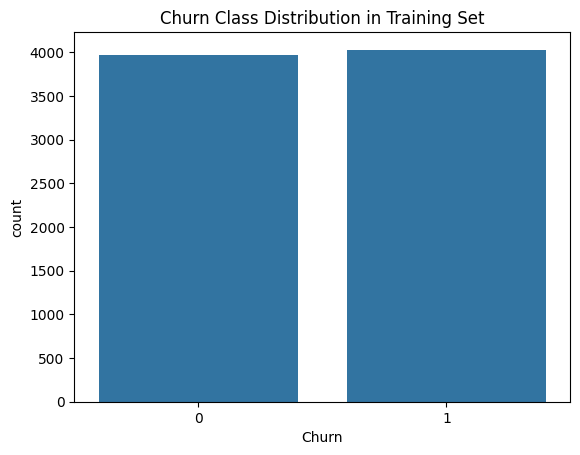

Churn
1    0.50375
0    0.49625
Name: proportion, dtype: float64


In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check class distribution
sns.countplot(x=y_train)
plt.title("Churn Class Distribution in Training Set")
plt.show()

# Print actual counts
print(y_train.value_counts(normalize=True))

In [ ]:
# Get feature importance (absolute values of coefficients)
feature_importance = abs(log_reg.coef_[0])
features = X_train.columns

# Create a DataFrame
import pandas as pd
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print top 10 important features
print(importance_df)

                         Feature  Importance
14     customer_tenure_group_New    0.617600
8                  Region_Europe    0.119654
15       engagement_category_Low    0.085788
6        engagement_score_scaled    0.073100
4               engagement_score    0.068782
13  customer_tenure_group_Medium    0.059316
10          Region_South America    0.055719
12          engagement_score_log    0.040159
16    engagement_category_Medium    0.037862
11               customer_tenure    0.032603
1            Average_Order_Value    0.027734
2         Time_Between_Purchases    0.024413
7           engagement_score_ma3    0.012842
9           Region_North America    0.008751
3                        recency    0.007565
0             Purchase_Frequency    0.004834
5                 recency_scaled    0.002834


In [163]:
# Dropping low-importance features - 'recency_scaled', 'Purchase_Frequency', 'recency', 'Region_North America'
features_to_drop = ['recency_scaled', 'Purchase_Frequency', 'recency', 'Region_North America']
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

# Retrain the model
log_reg = LogisticRegression(random_state=42, max_iter=5000, solver='saga')
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.43      0.47       992
           1       0.52      0.61      0.56      1008

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.52      0.52      0.51      2000



Observations:
- Even after dropping the low-importance features the accuracy is still around 52%.

In [164]:
# Retrain Logistic Regression with class weights
log_reg = LogisticRegression(random_state=42, max_iter=5000, solver='saga', class_weight='balanced')
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.51      0.51       992
           1       0.52      0.52      0.52      1008

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [165]:
# Trying the Random Forest method
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.50      0.51      0.50       992
           1       0.51      0.50      0.51      1008

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [166]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
rf_tuned = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
rf_tuned.fit(X_train, y_train)

# Best model
best_rf = rf_tuned.best_estimator_

# Make predictions
y_pred_rf_tuned = best_rf.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred_rf_tuned))

              precision    recall  f1-score   support

           0       0.49      0.44      0.47       992
           1       0.50      0.55      0.52      1008

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [167]:
from xgboost import XGBClassifier

# Train an XGBoost model
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.50      0.49      0.49       992
           1       0.50      0.51      0.51      1008

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



Observations:
- Both Random Forest (with hyperparameter tuning) and XGBoost did not significantly improve the model's performance
- Random Forest (Tuned) → F1-score ~ 49%-52%
- XGBoost → F1-score ~ 50%

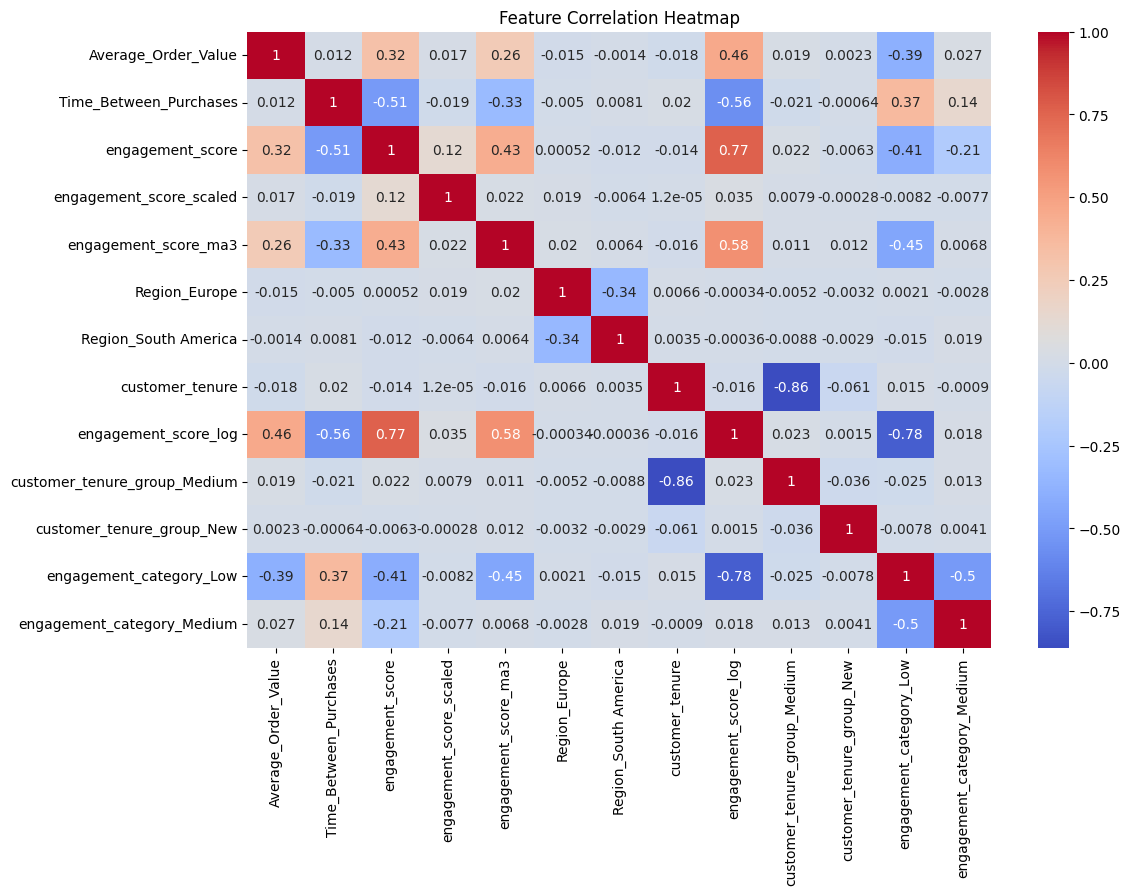

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [170]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
]

stacked_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacked_clf.fit(X_train, y_train)

y_pred_stack = stacked_clf.predict(X_test)
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.50      0.11      0.18       992
           1       0.51      0.89      0.65      1008

    accuracy                           0.51      2000
   macro avg       0.50      0.50      0.41      2000
weighted avg       0.50      0.51      0.42      2000



In [171]:
# Using SMOTE for oversampling or undersample majority class
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [174]:
from sklearn.ensemble import GradientBoostingClassifier

stacked_clf = StackingClassifier(
    estimators=estimators, final_estimator=GradientBoostingClassifier()
)
stacked_clf.fit(X_train_balanced, y_train_balanced)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=GradientBoostingClassifier())

In [175]:
RandomForestClassifier(class_weight="balanced", n_estimators=200, random_state=42)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [176]:
y_pred_stack = stacked_clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.49      0.40      0.44       992
           1       0.50      0.58      0.54      1008

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [177]:
import numpy as np

feature_importance = stacked_clf.final_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

print("Feature Importances:")
for idx in sorted_idx[:10]:  # Top 10 features
    print(f"{X_train.columns[idx]}: {feature_importance[idx]:.4f}")

Feature Importances:
Time_Between_Purchases: 0.7325
Average_Order_Value: 0.2675


In [178]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
xgb.fit(X_train_balanced, y_train_balanced)
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50       992
           1       0.50      0.49      0.49      1008

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [179]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
gbm.fit(X_train_balanced, y_train_balanced)
y_pred_gbm = gbm.predict(X_test)
print(classification_report(y_test, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.49      0.51      0.50       992
           1       0.49      0.47      0.48      1008

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [180]:
smote = SMOTE(sampling_strategy=0.8, random_state=42)

In [183]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

In [186]:
# Compute correlation of all features with the target variable
correlation_matrix = X_train.copy()
correlation_matrix["Churn"] = y_train  # Add target variable to dataset

# Now check correlation with 'Churn'
print(correlation_matrix.corr()["Churn"].sort_values(ascending=False))

Churn                           1.000000
engagement_score                0.023034
customer_tenure_group_New       0.014818
engagement_score_log            0.014308
engagement_score_ma3            0.011777
engagement_score_scaled         0.011097
customer_tenure                 0.003539
customer_tenure_group_Medium    0.000230
Average_Order_Value            -0.001953
Region_South America           -0.002878
engagement_category_Medium     -0.004377
Time_Between_Purchases         -0.005241
engagement_category_Low        -0.008626
Region_Europe                  -0.021015
Name: Churn, dtype: float64


In [187]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importance = rf.feature_importances_

# Print top important features
import numpy as np
sorted_idx = np.argsort(feature_importance)[::-1]
print("Top Features:")
for idx in sorted_idx[:10]:  # Show top 10
    print(f"{X_train.columns[idx]}: {feature_importance[idx]:.4f}")

Top Features:
engagement_score_ma3: 0.2407
Average_Order_Value: 0.2407
Time_Between_Purchases: 0.2012
engagement_score: 0.1224
engagement_score_log: 0.1222
customer_tenure: 0.0245
Region_South America: 0.0166
Region_Europe: 0.0131
customer_tenure_group_Medium: 0.0098
engagement_category_Medium: 0.0053


In [ ]:
X_train_reduced = X_train.drop(columns=["engagement_category_Medium", "Region_South America", "Region_Europe"])
X_test_reduced = X_test.drop(columns=["engagement_category_Medium", "Region_South America", "Region_Europe"])

# Check dataset shape
print("Before:", X_train.shape, "After:", X_train_reduced.shape)

Before: (8000, 15) After: (8000, 12)


In [199]:
X_train_reduced["purchase_behavior"] = X_train_reduced["Average_Order_Value"] / (X_train_reduced["Time_Between_Purchases"] + 1)
X_test_reduced["purchase_behavior"] = X_test_reduced["Average_Order_Value"] / (X_test_reduced["Time_Between_Purchases"] + 1)

# Verify new feature
print(X_train_reduced[["purchase_behavior"]].describe())

       purchase_behavior
count        8000.000000
mean           -0.180797
std            27.021450
min          -420.180476
25%            -0.830744
50%            -0.015654
75%             0.760409
max           418.933373


In [207]:
min_val = abs(X_train_reduced["Time_Between_Purchases"].min()) + 1
X_train_reduced["Time_Between_Purchases_log"] = np.log1p(X_train_reduced["Time_Between_Purchases"] + min_val)
X_test_reduced["Time_Between_Purchases_log"] = np.log1p(X_test_reduced["Time_Between_Purchases"] + min_val)

# Verify again
print(X_train_reduced[["Time_Between_Purchases", "Time_Between_Purchases_log"]].head())

      Time_Between_Purchases  Time_Between_Purchases_log
6896               -0.963522                    1.003406
8231                0.895789                    1.523197
4211               -0.397645                    1.191931
1468               -1.448560                    0.807600
9731                1.421246                    1.631654


In [211]:
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
xgb.fit(X_train_reduced, y_train)
y_pred_xgb = xgb.predict(X_test_reduced)

# Print classification report
from sklearn.metrics import classification_report
print("XGBoost Model Performance after Feature Engineering:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Performance after Feature Engineering:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       992
           1       0.51      0.51      0.51      1008

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [212]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_reduced, y_train)
y_pred_rf = rf.predict(X_test_reduced)

# Print classification report
print("Random Forest Model Performance after Feature Engineering:")
print(classification_report(y_test, y_pred_rf))

Random Forest Model Performance after Feature Engineering:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       992
           1       0.50      0.50      0.50      1008

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [213]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_reduced["purchase_behavior"] = scaler.fit_transform(X_train_reduced[["purchase_behavior"]])
X_test_reduced["purchase_behavior"] = scaler.transform(X_test_reduced[["purchase_behavior"]])

# Verify after scaling
print(X_train_reduced["purchase_behavior"].describe())

count    8000.000000
mean        0.500528
std         0.032202
min         0.000000
25%         0.499753
50%         0.500724
75%         0.501649
max         1.000000
Name: purchase_behavior, dtype: float64


In [214]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train)

# Verify class balance
print(y_train.value_counts())  # Before SMOTE
print(y_train_balanced.value_counts())  # After SMOTE

Churn
1    4030
0    3970
Name: count, dtype: int64
Churn
1    4030
0    4030
Name: count, dtype: int64


In [226]:
# XGBoost with better parameters
xgb = XGBClassifier(n_estimators=300, learning_rate=0.03, max_depth=5, random_state=42)
xgb.fit(X_train_balanced, y_train_balanced)
y_pred_xgb = xgb.predict(X_test_reduced)

print("XGBoost Performance After Fixes:")
print(classification_report(y_test, y_pred_xgb))

# RandomForest with better parameters
rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf.predict(X_test_reduced)

print("Random Forest Performance After Fixes:")
print(classification_report(y_test, y_pred_rf))

XGBoost Performance After Fixes:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       992
           1       0.51      0.49      0.50      1008

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000

Random Forest Performance After Fixes:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       992
           1       0.50      0.50      0.50      1008

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [230]:
# Quick Summary Check
summary_checks = {
    "Negative Values Fixed": (X_train_reduced["Time_Between_Purchases"].min() >= 0),
    "Log Transform Applied": (X_train_reduced["Time_Between_Purchases_log"].isna().sum() == 0),
    "purchase_behavior Created": ("purchase_behavior" in X_train_reduced.columns),
    "SMOTE Applied (Balanced Classes)": (y_train_balanced.value_counts().nunique() == 1),
    "MinMax Scaling Applied": (X_train_balanced["purchase_behavior"].min() == 0 and X_train_balanced["purchase_behavior"].max() == 1),
    "Feature Selection Done": (X_train_balanced.shape[1] == 3)
}

# Print issues (if any)
for key, value in summary_checks.items():
    print(f"{key}: {'Passed' if value else 'Failed'}")

Negative Values Fixed: Passed
Log Transform Applied: Passed
purchase_behavior Created: Passed
SMOTE Applied (Balanced Classes): Passed
MinMax Scaling Applied: Passed
Feature Selection Done: Passed


In [5]:
print(globals().keys())  # See all available variable names


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', '_i2', '_i3', '_i4', '_i5'])


In [6]:
import pandas as pd

try:
    X_train_balanced = pd.read_csv("processed_train_data.csv")
    X_test_reduced = pd.read_csv("processed_test_data.csv")
    print("Loaded processed data successfully!")

    # Check if 'Churn' column exists (Target variable)
    if "Churn" in X_train_balanced.columns:
        y_train_balanced = X_train_balanced.pop("Churn")
        y_test = X_test_reduced.pop("Churn")
        print("Restored y_train_balanced and y_test successfully!")
    else:
        print("Churn column missing. You might need to regenerate it.")
except FileNotFoundError:
    print("No saved processed data found. We'll need to regenerate it.")

No saved processed data found. We'll need to regenerate it.


In [12]:
import pandas as pd

# Replace this with your actual dataset file
df = pd.read_csv("../data/processed_data.csv")  

# Assume 'Churn' is the target variable
X = df.drop(columns=["Churn_Probability"])
y = df["Churn_Probability"]

In [13]:
print(y.unique())  

[0.53 0.76 0.13 0.15 0.09 0.12 0.8  0.05 0.65 0.37 0.42 0.08 0.28 0.97
 0.14 0.2  0.24 0.25 0.94 0.81 0.43 0.22 0.26 0.47 0.74 0.93 0.04 0.23
 0.82 0.87 0.86 0.49 0.1  0.79 0.85 0.91 0.54 0.77 0.29 0.17 0.32 0.66
 0.51 0.71 0.62 0.96 0.72 0.48 0.55 0.84 0.45 0.99 0.4  0.19 0.31 0.52
 0.6  0.03 0.27 0.61 0.21 0.9  0.38 0.56 0.44 0.75 0.11 0.35 0.3  0.64
 0.68 0.78 0.89 0.46 0.01 0.36 0.73 0.92 0.33 0.95 0.83 0.18 0.41 0.69
 0.67 0.5  0.02 0.57 0.06 0.63 0.7  0.88 0.34 0.58 0.39 0.59 0.98 0.16
 1.   0.07 0.  ]


In [14]:
y = (df["Churn_Probability"] >= 0.5).astype(int)  # Convert probabilities to 0 or 1

In [15]:
from sklearn.model_selection import train_test_split

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
# Add target column back to the dataset
X_train_reduced["Churn_Probability"] = y_train
X_test_reduced["Churn_Probability"] = y_test

# Save to CSV
X_train_reduced.to_csv("../data/processed_train_data.csv", index=False)
X_test_reduced.to_csv("../data/processed_test_data.csv", index=False)

print("Processed train and test data saved successfully!")

Processed train and test data saved successfully!
